In [1]:
#!pip install opencv-python opencv-contrib-python

## Import Libraries

In [2]:
import os
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq

## Data Exploration and Visualization

### Dataset Paths

In [3]:
train_path = 'dataset/train'
test_path = 'dataset/test'
no_clusters = 100
kernel_type = 'linear'

### Dataset Images

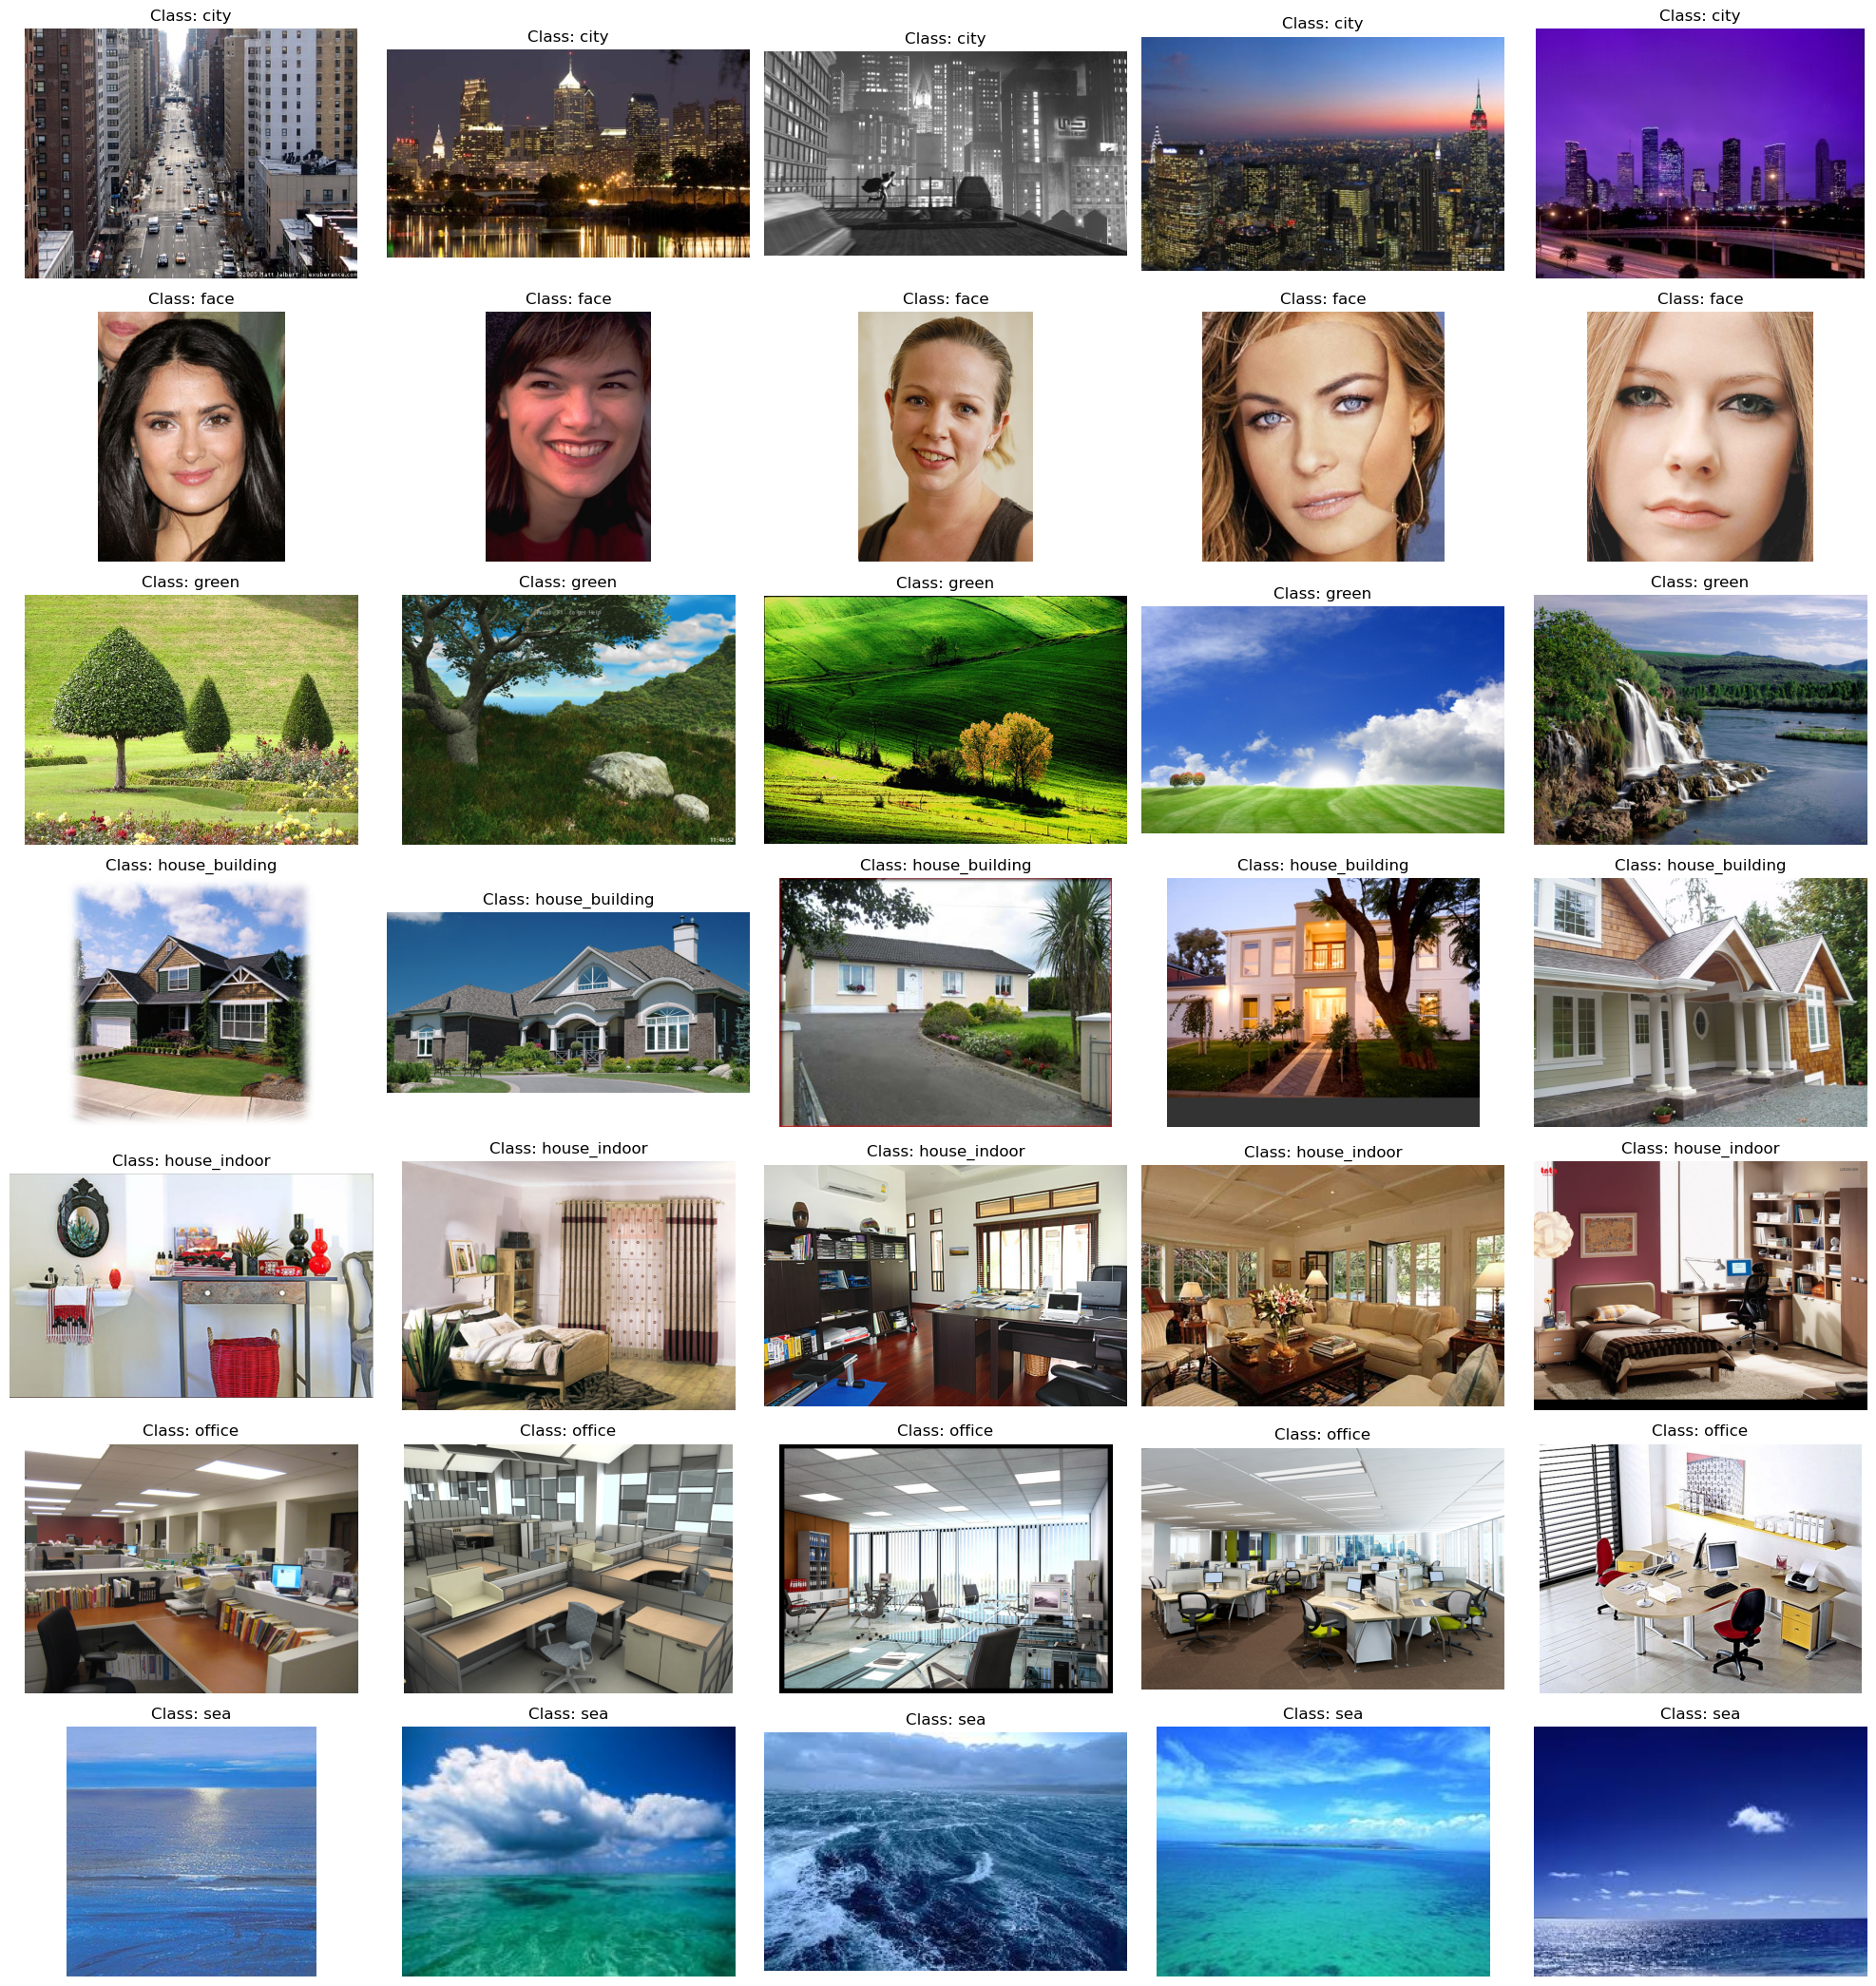

In [4]:
def display_sample_images(path, num_samples=3):
    classes = os.listdir(path)
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(num_samples * 4, len(classes) * 3))

    for i, cls in enumerate(classes):
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for j in range(num_samples):
            img_path = join(path, cls, images[j])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if len(classes) == 1:
                ax = axs[j]
            else:
                ax = axs[i, j]
            ax.imshow(img)
            ax.set_title(f"Class: {cls}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from training dataset
display_sample_images(train_path, num_samples=5)

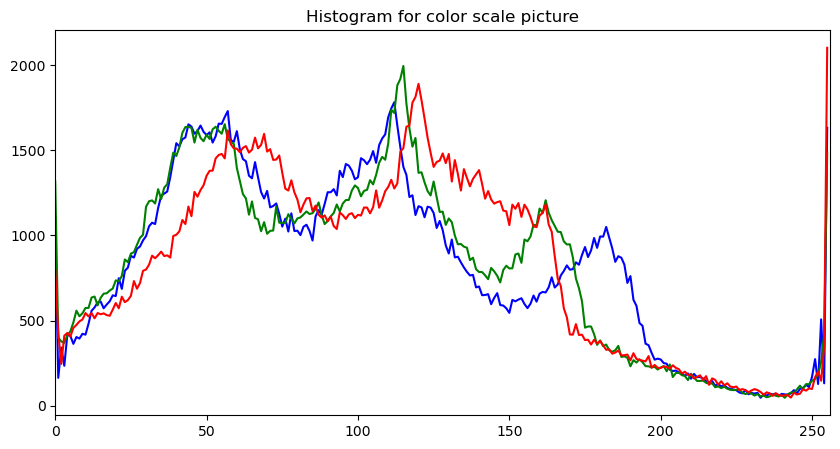

In [5]:
def plot_image_histogram(image_path):
    img = cv2.imread(image_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, 256])
    plt.title('Histogram for color scale picture')
    plt.show()

# Plot histogram for an example image
example_image_path = join(train_path, os.listdir(train_path)[0], os.listdir(join(train_path, os.listdir(train_path)[0]))[0])
plot_image_histogram(example_image_path)

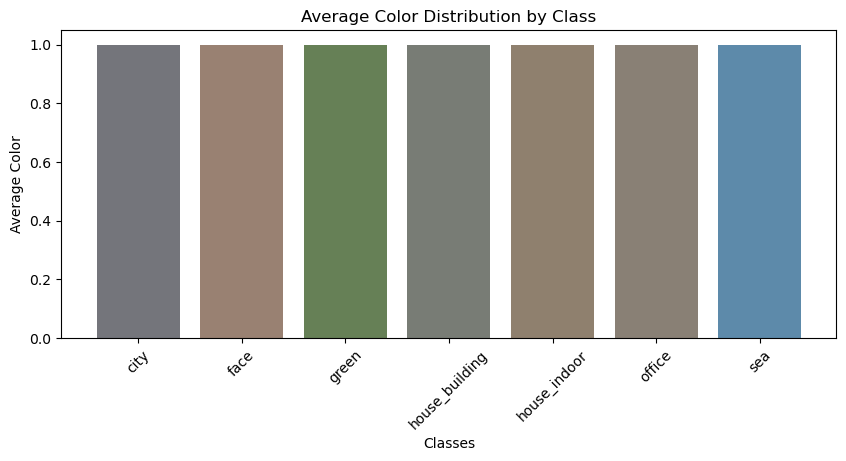

In [6]:
def plot_average_color_distribution(path):
    classes = os.listdir(path)
    avg_color_per_class = {cls: np.zeros(3, dtype=np.float64) for cls in classes}
    count_per_class = {cls: 0 for cls in classes}

    for cls in classes:
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for img_file in images:
            img = cv2.imread(join(path, cls, img_file))
            avg_color = img.mean(axis=0).mean(axis=0)
            avg_color_per_class[cls] += avg_color
            count_per_class[cls] += 1

    for cls in classes:
        avg_color_per_class[cls] /= count_per_class[cls]

    # Plotting
    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(len(classes)), [1]*len(classes), color=[(avg_color_per_class[cls][2]/255, avg_color_per_class[cls][1]/255, avg_color_per_class[cls][0]/255) for cls in classes])
    plt.xlabel('Classes')
    plt.ylabel('Average Color')
    plt.title('Average Color Distribution by Class')
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.show()

# Call the function with the correct path
plot_average_color_distribution(train_path)

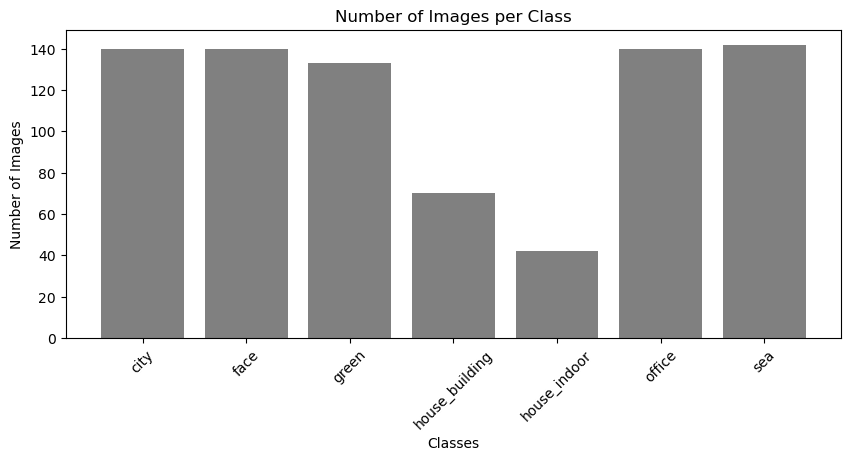

In [7]:
def plot_class_distribution(path):
    class_counts = {}
    classes = os.listdir(path)
    for cls in classes:
        class_counts[cls] = len([name for name in listdir(join(path, cls)) if isfile(join(path, cls, name))])

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.bar(class_counts.keys(), class_counts.values(), color='grey')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.show()

# Call the function
plot_class_distribution(train_path)

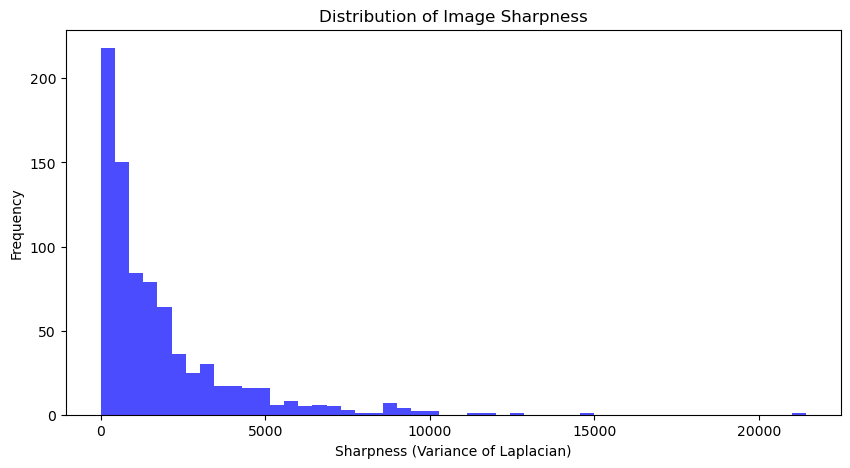

In [8]:
def plot_image_sharpness_distribution(path):
    sharpness_values = []
    classes = os.listdir(path)
    for cls in classes:
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for image in images:
            img = cv2.imread(join(path, cls, image), 0)
            laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
            sharpness_values.append(laplacian_var)

    plt.figure(figsize=(10, 5))
    plt.hist(sharpness_values, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Sharpness (Variance of Laplacian)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Sharpness')
    plt.show()

# Call the function
plot_image_sharpness_distribution(train_path)

## Functions

In [9]:
def getFiles(train, path):
    images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            images.append(os.path.join(folder_path, file))
    if train:
        np.random.shuffle(images)
    return images

# Function to read images
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img, (64, 64))

## Visualize Keypoints

In [11]:
image_paths = getFiles(True, train_path)
print(len(image_paths))
#print(image_paths)

807


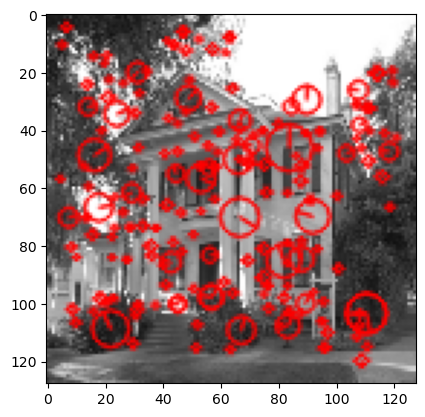

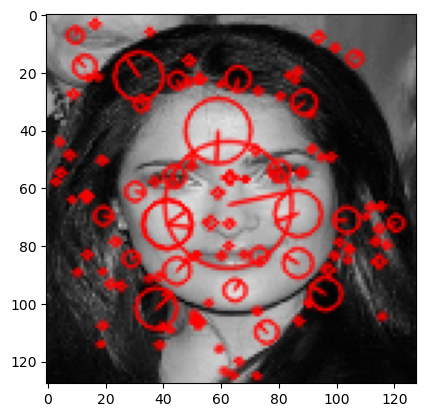

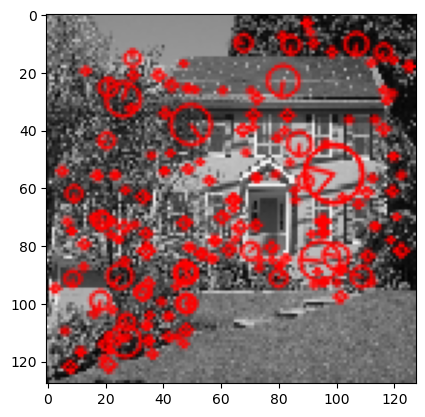

In [12]:
# SIFT Extractor
extractor = cv2.SIFT_create()

images_training = []
bw_images = []
keypoints = []
descriptors = []

for x in image_paths:
    # Read the image from the file path
    img = cv2.imread(x)
    img = cv2.resize(img, (128, 128))
    images_training.append(np.array(img))
    
    if img is None:
        # Handle case where image cannot be read
        print(f"Unable to read image: {img_path}")
        continue
    
    # Convert the image to grayscale (assuming your extractor works with grayscale images)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bw_images.append(gray_img)
    
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(gray_img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)
    
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show() 

In [13]:
#print(len(keypoints))
#print(keypoints)
#print(len(descriptors))
#print(descriptors)

## Building CodeBook

In [14]:
from scipy.cluster.vq import kmeans

# Concatenate all descriptors into a single array
all_descriptors = np.concatenate(descriptors)

# Perform k-means clustering
k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

## Saving CodeBook

In [15]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3) 

['bovw-codebook.pkl']

## Load CodeBook

In [16]:
# load the visual features, number of clusters, and codebook 
k, codebook = joblib.load("bovw-codebook.pkl")

## Building Sparse Vectors

### 1. Vector Quantization
(visual feature representations -> visual words)

In [17]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [18]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([100, 179,   4, 167, 193]), 201)

In [19]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[84].shape  # (all have the same dimensionality)

(128,)

### 2. Frequency Count

In [20]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [21]:
frequency_vectors.shape

(807, 200)

In [22]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [84,  22,  45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

84: 0.0
22: 0.0
45: 2.0
172: 3.0


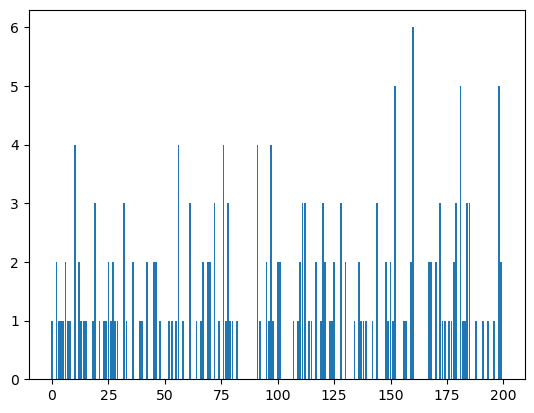

In [23]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

### 3. Tf-idf

In [24]:
# N is the number of images, i.e. the size of the dataset
N = len(image_paths)

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)
print(df.shape, df[:5])

idf = np.log(N/ df)
print(idf.shape, idf[:5])

tfidf = frequency_vectors * idf
print(tfidf.shape, tfidf[0][:5])

(200,) [348 256 349 305 392]
(200,) [0.84112119 1.14814622 0.83825175 0.97301189 0.72206183]
(807, 200) [0.84112119 0.         1.67650349 0.97301189 0.72206183]


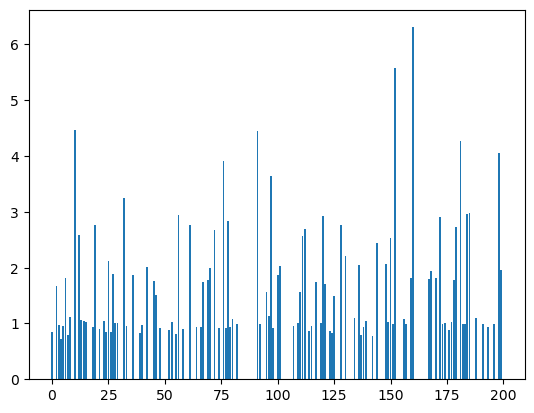

In [25]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

In [28]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()
    # get search image vector
    a = tfidf[i]
    b = tfidf
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    print("Min cosine similarity:", round(np.min(cosine_similarity),1))
    print("Max cosine similarity:", np.max(cosine_similarity))
    print("-----------------------------------------------------")
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap='gray')
        plt.show()

Search image:


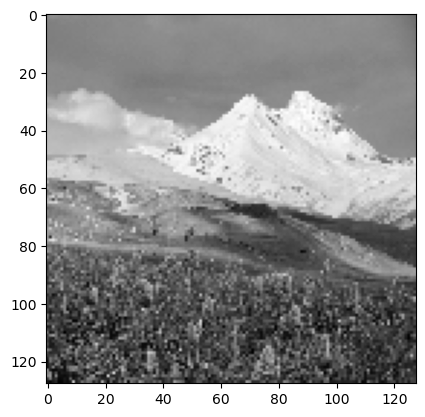

Min cosine similarity: 0.0
Max cosine similarity: 0.9999999999999999
-----------------------------------------------------
10: 1.0


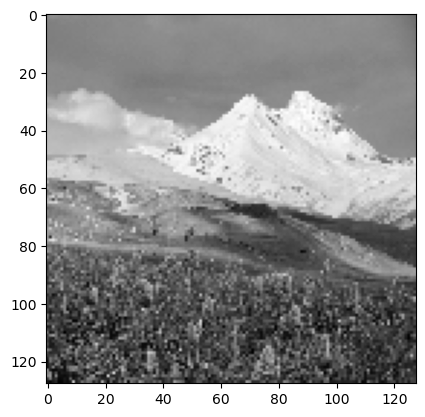

19: 0.5423


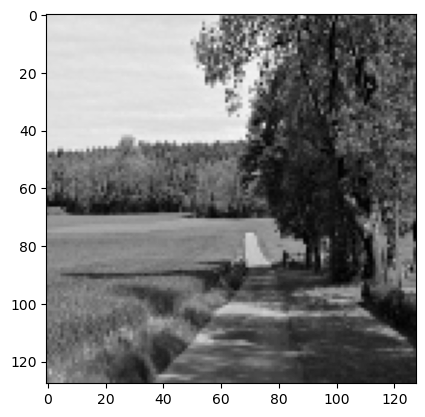

744: 0.5154


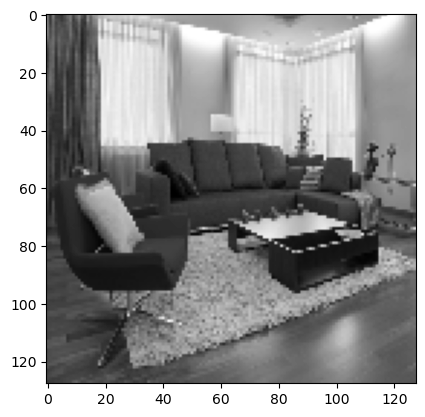

599: 0.4979


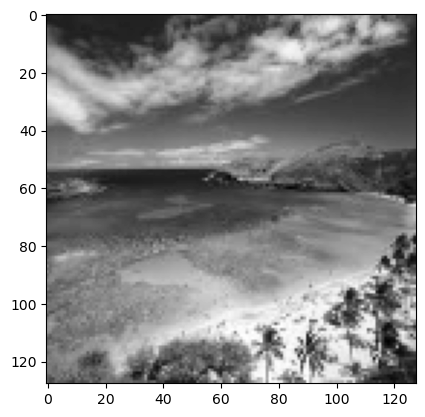

543: 0.4877


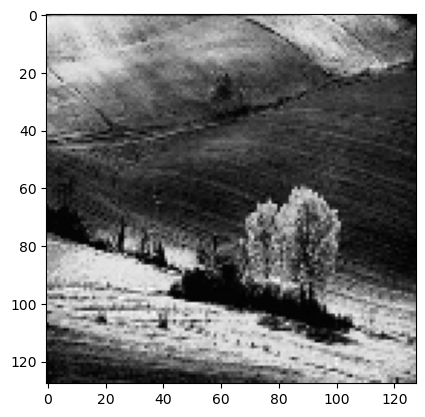

In [29]:
search(10)